# Import Libraries

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
import os
from download_dataset import download_datasets
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Flatten, Input, Conv2D, MaxPooling2D
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as k
from tensorflow.keras.callbacks import ModelCheckpoint

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

# Download data

In [4]:


# Change this to your desired directory
data_dir = os.path.join(os.getcwd(), 'dataset')
print(f'data_dir: {data_dir}')
# Make sure that the destination_dir is available
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
# Download the dataset
download_datasets(data_dir)

data_dir: /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/dataset


# Read Data

In [5]:
train = pd.read_csv(data_dir+'/train_labels.csv', dtype=str)
train.id = train.id + '.tif'
train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835.tif,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif,1
2,755db6279dae599ebb4d39a9123cce439965282d.tif,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif,0
4,068aba587a4950175d04c680d38943fd488d6a9d.tif,0


# Label Distribution

In [6]:
(train.label.value_counts() / len(train)).to_frame().sort_index().T

label,0,1
count,0.594969,0.405031


# Show sample images

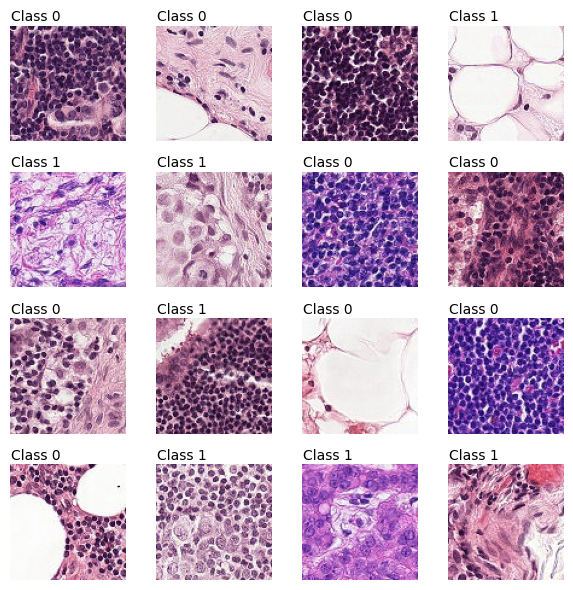

In [7]:
train_path = data_dir+"/train"

sample = train.sample(n=16).reset_index()

plt.figure(figsize=(6,6))

for i, row in sample.iterrows():

    img = mpimg.imread(f'{train_path}/{row.id}')    
    label = row.label

    plt.subplot(4,4,i+1)
    plt.imshow(img)
    plt.text(0, -5, f'Class {label}', color='k')
        
    plt.axis('off')

plt.tight_layout()
plt.show()

# Training and Validation Set

In [8]:
train_df, valid_df = train_test_split(train, test_size=0.2, random_state=1, stratify=train.label)

# Data Generators

In [9]:
class CustomImageDataGenerator(ImageDataGenerator):
    def flow_from_dataframe(self, *args, **kwargs):
        generator = super().flow_from_dataframe(*args, **kwargs)
        # Convert labels to integer
        def custom_data_generator():
            for batch in generator:
                images, labels = batch
                labels = labels.astype(np.int32)  # Ensure labels are integers
                yield images, labels
                
        return custom_data_generator()

# Initialize data generators
train_datagen = CustomImageDataGenerator(rescale=1/255)
validation_datagen = CustomImageDataGenerator(rescale=1/255)
BATCH_SIZE = 64

train_loader = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col='id',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=1,
    shuffle=True,
    class_mode='sparse',
    target_size=(96, 96)
)

valid_loader = validation_datagen.flow_from_dataframe(
    dataframe=valid_df,
    directory=train_path,
    x_col='id',
    y_col='label',
    batch_size=BATCH_SIZE,
    seed=1,
    shuffle=True,
    class_mode='sparse',
    target_size=(96, 96)
)


Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [10]:
# Retrieve a batch of data from the train_loader
images, labels = next(train_loader)

# Check the shape and type of images and labels
print(f'Training images shape: {images.shape}')
print(f'Training labels shape: {labels.shape}')
print(f'Training images type: {images.dtype}')
print(f'Training labels type: {labels.dtype}')

# Retrieve a batch of data from the valid_loader
images_val, labels_val = next(valid_loader)

# Check the shape and type of images and labels
print(f'Validation images shape: {images_val.shape}')
print(f'Validation labels shape: {labels_val.shape}')
print(f'Validation images type: {images_val.dtype}')
print(f'Validation labels type: {labels_val.dtype}')


Training images shape: (64, 96, 96, 3)
Training labels shape: (64,)
Training images type: float32
Training labels type: int32
Validation images shape: (64, 96, 96, 3)
Validation labels shape: (64,)
Validation images type: float32
Validation labels type: int32


In [11]:
total_train_samples = len(valid_df)  # or use the length of the training subset
total_valid_samples = len(valid_df)  # or use the length of the validation subset

# Batch size used
BATCH_SIZE = 64

# Calculate steps per epoch
TR_STEPS = total_train_samples // BATCH_SIZE
VA_STEPS = total_valid_samples // BATCH_SIZE

print(f'Training steps per epoch: {TR_STEPS}')
print(f'Validation steps per epoch: {VA_STEPS}')

Training steps per epoch: 687
Validation steps per epoch: 687


# Create a model based on trained VGG 19

In [10]:

# Load the VGG19 model without the top layer
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Freeze the convolutional base
for layer in base_model.layers:
    layer.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = Flatten()(x)  # Flatten the output of the convolutional base
x = Dense(16, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(8, activation='relu')(x)
x = Dropout(0.5)(x)
x = BatchNormalization()(x)
x = Dense(2, activation='softmax')(x)  # For binary classification (2 classes)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
              metrics=['accuracy'])

# Model summary
model.summary()


2024-07-15 23:00:41.305097: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-15 23:00:41.334171: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-15 23:00:41.334219: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-15 23:00:41.337669: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-15 23:00:41.337715: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 96, 96, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        73,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             

 Total params: 20,098,314 (76.67 MB)

 Trainable params: 73,914 (288.73 KB)

 Non-trainable params: 20,024,400 (76.39 MB)

# Train the model

In [11]:
epochs = 50
path_to_save_best_model = os.path.join(os.getcwd(),'result',f'{epochs}_epcohs_bestmodel.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=path_to_save_best_model,  # Path to save the best model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='max',                # Mode for monitoring (maximizing validation accuracy)
    verbose=1                  # Print messages when saving the model
)
history = model.fit(
    x=train_loader,
    steps_per_epoch=TR_STEPS,
    epochs=epochs,
    validation_data=valid_loader,
    validation_steps=VA_STEPS,
    verbose=1,
    callbacks=[checkpoint_callback]  # Include the ModelCheckpoint callback here
)
print('Training is done.')

Epoch 1/50


I0000 00:00:1721098843.286930  598694 service.cc:145] XLA service 0x7f858c005cb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721098843.286985  598694 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-07-15 23:00:43.316226: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-15 23:00:43.533499: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  3/687 ━━━━━━━━━━━━━━━━━━━━ 31s 46ms/step - accuracy: 0.4592 - loss: 1.0794   

I0000 00:00:1721098852.740152  598694 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.6699 - loss: 0.6249
Epoch 1: val_accuracy improved from -inf to 0.78164, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/50_epcohs_bestmodel.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 73s 92ms/step - accuracy: 0.6699 - loss: 0.6248 - val_accuracy: 0.7816 - val_loss: 0.4591
Epoch 2/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7473 - loss: 0.5227
Epoch 2: val_accuracy improved from 0.78164 to 0.80934, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/50_epcohs_bestmodel.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 58s 85ms/step - accuracy: 0.7473 - loss: 0.5227 - val_accuracy: 0.8093 - val_loss: 0.4265
Epoch 3/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7633 - loss: 0.4906
Epoch 3: val_accuracy did not improve from 0.80934
687/687 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.7633 - loss: 0.4906 - val_accuracy: 0.8055 - val_loss: 0.4263
Epo

# Plot training and validation accuracy and loss

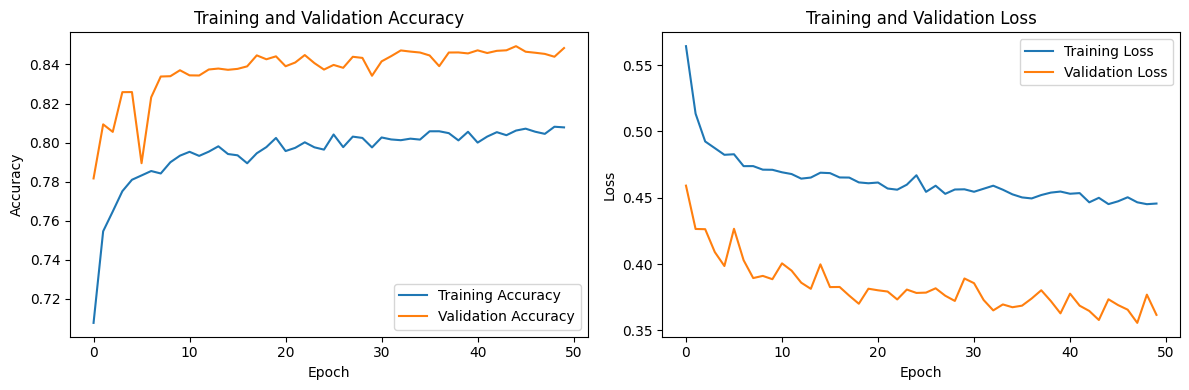

In [16]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
# make plots
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

# load the trained model and classify test scenes

In [17]:
model.load_weights(path_to_save_best_model)
# create test data loader
path2test_scenes = os.path.join(data_dir, "sample_submission.csv")
test_data_df = pd.read_csv(path2test_scenes)
test_data_df.id = test_data_df.id+'.tif'
test_data_df.head()
train_path = os.path.join(data_dir, "test")
test_datagen = ImageDataGenerator(rescale=1/255)
# Create the test data loader
test_loader = test_datagen.flow_from_dataframe(
    dataframe=test_data_df,         # DataFrame containing image filenames and invalid labels
    directory=train_path,      # Directory where the test images are located
    x_col='id',                # Column in test_df containing image filenames
    y_col=None,                # No valid labels, so specify None
    batch_size=BATCH_SIZE,
    seed=1,
    shuffle=False,             # Do not shuffle test images
    class_mode=None,           # No class labels
    target_size=(96, 96)       # Resize images to the desired size
)
probabilities = model.predict(test_loader)
print(f'probabilities.shape: {probabilities.shape}')
print(f'probabilities[0:10] = {probabilities[0:10]}')

Found 57458 validated image filenames.
  4/898 ━━━━━━━━━━━━━━━━━━━━ 49s 55ms/step

/home/saeid23/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 37s 41ms/step
probabilities.shape: (57458, 2)
probabilities[0:5] = [[0.74332565 0.25667444]
 [0.5723773  0.42762265]
 [0.98487604 0.01512389]
 [0.68631244 0.3136876 ]
 [0.95577306 0.04422688]]


# Save only probabilities for class 1 (Cancer)

In [19]:
submission =  pd.read_csv(path2test_scenes)
submission.label = probabilities[:,1]
path2save_results = os.path.join(os.getcwd(),'result',f'{epochs}_epochs_VGG19_submission.csv')
submission.to_csv(path2save_results, header=True, index=False)

# Using simple model

In [20]:
# Define the CNN model
def create_model(input_shape):
    model = Sequential()

    # First convolutional layer
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    # Second convolutional layer
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Third convolutional layer
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    # Flatten the output and add Dense layers
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(2))  # 2 output nodes for the logits

    return model

# Create the model
input_shape = (96, 96, 3)  # Assuming the input images are 96x96x3
simple_model = create_model(input_shape)

# Compile the model with the appropriate loss function and optimizer
# Compile the model with the appropriate loss function, optimizer, and metrics
simple_model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Print the model summary
simple_model.summary()


/home/saeid23/miniconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,732,034 (6.61 MB)

 Trainable params: 1,732,034 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

# Train simple model

In [21]:
epochs = 50
path_to_save_best_simple_model = os.path.join(os.getcwd(),'result',f'{epochs}_epcohs_best_simple_model.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=path_to_save_best_simple_model,  # Path to save the best model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='max',                # Mode for monitoring (maximizing validation accuracy)
    verbose=1                  # Print messages when saving the model
)
history_simple_model = simple_model.fit(
    x=train_loader,
    steps_per_epoch=TR_STEPS,
    epochs=epochs,
    validation_data=valid_loader,
    validation_steps=VA_STEPS,
    verbose=1,
    callbacks=[checkpoint_callback]  # Include the ModelCheckpoint callback here
)
print('Training simple_model is done.')

Epoch 1/50
686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.7313 - loss: 0.5447
Epoch 1: val_accuracy improved from -inf to 0.79138, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/50_epcohs_best_simple_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 33s 41ms/step - accuracy: 0.7314 - loss: 0.5445 - val_accuracy: 0.7914 - val_loss: 0.4507
Epoch 2/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8006 - loss: 0.4468
Epoch 2: val_accuracy improved from 0.79138 to 0.81851, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/50_epcohs_best_simple_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 29s 42ms/step - accuracy: 0.8006 - loss: 0.4467 - val_accuracy: 0.8185 - val_loss: 0.4035
Epoch 3/50
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8204 - loss: 0.4088
Epoch 3: val_accuracy improved from 0.81851 to 0.84582, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/5

# Plot the loss and accuracy

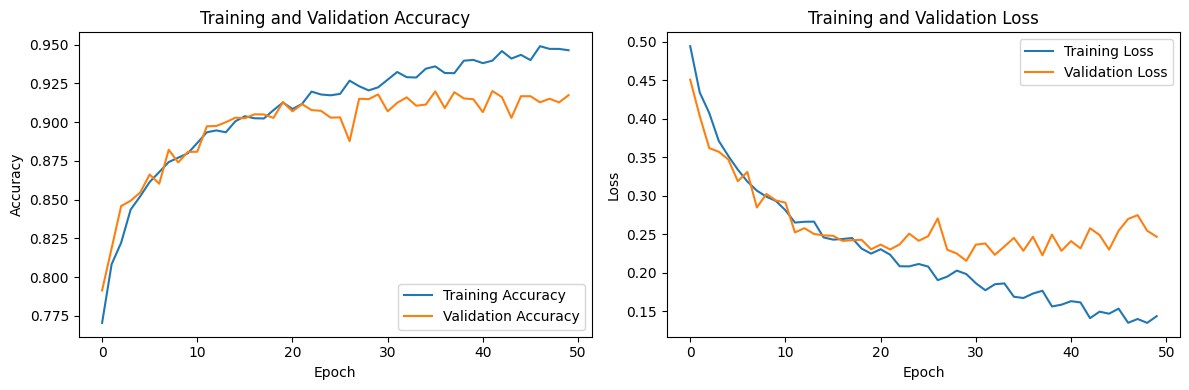

In [30]:
train_acc = history_simple_model.history['accuracy']
val_acc = history_simple_model.history['val_accuracy']
train_loss = history_simple_model.history['loss']
val_loss = history_simple_model.history['val_loss']
# make plots
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

# load the trained simple model and classify test scenes

In [27]:
simple_model.load_weights(path_to_save_best_simple_model)
logits = simple_model.predict(test_loader)
probabilities_simple_model = tf.nn.softmax(logits, axis=-1)

print(f'probabilities.shape: {probabilities_simple_model.shape}')
print(f'probabilities[0:10] = {probabilities_simple_model[0:10]}')

Found 57458 validated image filenames.
 10/898 ━━━━━━━━━━━━━━━━━━━━ 16s 19ms/step

/home/saeid23/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 17s 19ms/step
probabilities.shape: (57458, 2)
probabilities[0:10] = [[9.8122108e-01 1.8778970e-02]
 [9.9984777e-01 1.5217790e-04]
 [9.9997294e-01 2.7102522e-05]
 [9.9968743e-01 3.1258099e-04]
 [9.9690682e-01 3.0931998e-03]
 [3.3932664e-02 9.6606731e-01]
 [9.0361571e-01 9.6384332e-02]
 [8.2546782e-01 1.7453216e-01]
 [9.7381377e-01 2.6186269e-02]
 [8.0875117e-01 1.9124889e-01]]


# Save only probabilities for class 1 (Cancer)

In [28]:
submission =  pd.read_csv(path2test_scenes)
submission.label = probabilities_simple_model[:,1]
path2save_results = os.path.join(os.getcwd(),'result',f'{epochs}_epochs_submission_simple_model.csv')
submission.to_csv(path2save_results, header=True, index=False)

# More comlex Model

In [13]:
# Input layer
input_layer = layers.Input(shape=(96, 96, 3), name='input')

# First Layer
x = layers.Conv2D(filters=8, kernel_size=3, strides=2, padding='same')(input_layer)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.25)(x)

# Second Layer
x = layers.Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.25)(x)

# Third Layer
x = layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.25)(x)

# Fourth Layer
x = layers.Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)
x = layers.Dropout(rate=0.25)(x)

# Fifth layer as global max pooling
x = layers.GlobalMaxPooling2D()(x)


# Flatten
x = layers.Flatten()(x)

# Dense Layer
x = layers.Dense(units=128, activation='relu')(x)
x = layers.Dropout(rate=0.25)(x)

# Classification
output_layer = layers.Dense(units=1, activation='sigmoid')(x)

# Create a model
complex_model = models.Model(input_layer, output_layer)
#model.summary()

complex_model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              metrics=['accuracy'])

# Print the model summary
complex_model.summary()


2024-07-16 01:09:55.813472: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 01:09:55.947991: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 01:09:55.948040: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 01:09:55.951052: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:07:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-07-16 01:09:55.951110: I external/local_xla/xla/stream_executor

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input (InputLayer)              │ (None, 96, 96, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 48, 48, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 48, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24, 24, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 64)             │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 33,457 (130.69 KB)

 Trainable params: 33,217 (129.75 KB)

 Non-trainable params: 240 (960.00 B)

In [15]:
epochs= 100
path_to_save_best_complex_model = os.path.join(os.getcwd(),'result',f'{epochs}_epcohs_best_complex_model.keras')
checkpoint_callback = ModelCheckpoint(
    filepath=path_to_save_best_complex_model,  # Path to save the best model
    monitor='val_accuracy',    # Metric to monitor
    save_best_only=True,        # Save only the best model
    mode='max',                # Mode for monitoring (maximizing validation accuracy)
    verbose=1                  # Print messages when saving the model
)
history_complex_model = complex_model.fit(
    x=train_loader,
    steps_per_epoch=TR_STEPS,
    epochs=epochs,
    validation_data=valid_loader,
    validation_steps=VA_STEPS,
    verbose=1,
    callbacks=[checkpoint_callback]  # Include the ModelCheckpoint callback here
)
print('Training simple_model is done.')


Epoch 1/100


I0000 00:00:1721106623.237874  623028 service.cc:145] XLA service 0x7fa084007b70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721106623.238483  623028 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2024-07-16 01:10:23.287308: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-16 01:10:23.560366: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


 10/687 ━━━━━━━━━━━━━━━━━━━━ 13s 20ms/step - accuracy: 0.4780 - loss: 1.3573

I0000 00:00:1721106629.593178  623028 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7483 - loss: 0.5559
Epoch 1: val_accuracy improved from -inf to 0.65176, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/100_epcohs_best_complex_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 36s 40ms/step - accuracy: 0.7484 - loss: 0.5556 - val_accuracy: 0.6518 - val_loss: 0.6788
Epoch 2/100
686/687 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8227 - loss: 0.4039
Epoch 2: val_accuracy improved from 0.65176 to 0.75817, saving model to /home/saeid23/Github_ML_Projects/histopathologic-cancer-detection/result/100_epcohs_best_complex_model.keras
687/687 ━━━━━━━━━━━━━━━━━━━━ 27s 39ms/step - accuracy: 0.8227 - loss: 0.4038 - val_accuracy: 0.7582 - val_loss: 0.4930
Epoch 3/100
687/687 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8451 - loss: 0.3659
Epoch 3: val_accuracy did not improve from 0.75817
687/687 ━━━━━━━━━━━━━━━━━━━━ 27s 40ms/step - accuracy: 0.8451 - loss: 0.3659 - val_accuracy: 0.6821 

# Plot

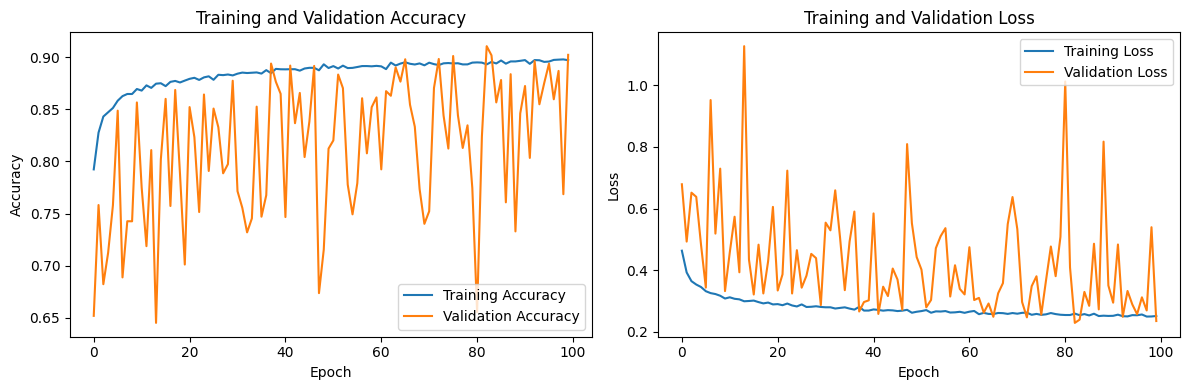

In [16]:
train_acc = history_complex_model.history['accuracy']
val_acc = history_complex_model.history['val_accuracy']
train_loss = history_complex_model.history['loss']
val_loss = history_complex_model.history['val_loss']
# make plots
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.subplot(1,2,2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')


plt.tight_layout()
plt.show()

In [17]:
complex_model.load_weights(path_to_save_best_complex_model)
probabilities_complex_model = complex_model.predict(test_loader)
print(f'probabilities.shape: {probabilities_complex_model.shape}')
print(f'probabilities[0:10] = {probabilities_complex_model[0:10]}')

/home/saeid23/miniconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 26s 28ms/step
probabilities.shape: (57458, 1)
probabilities[0:10] = [[0.22867207]
 [0.06830155]
 [0.12475447]
 [0.09083042]
 [0.15272097]
 [0.95719236]
 [0.8334735 ]
 [0.57426655]
 [0.01560694]
 [0.15402357]]


In [18]:
submission =  pd.read_csv(path2test_scenes)
submission.label = probabilities_complex_model
path2save_results = os.path.join(os.getcwd(),'result',f'{epochs}_epochs_submission_complex_model.csv')
submission.to_csv(path2save_results, header=True, index=False)